In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap1 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = pklload("./database/01_nh_ghmatch.pickle")
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp)

# mode = 'nh2'
# iout = 797
# repo, rurmode, dp = mode2repo(mode)
# snap2 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
# snap2s = uri.TimeSeries(snap2)
# snap2s.read_iout_avail()
# nout2 = snap2s.iout_avail['iout']
# gal2s = pklload("./database/01_nh2_ghmatch.pickle")
# hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp)

result1s = pklload(f"./database/03_MWA1s.pickle")
# result2s = pklload(f"./database/03_MWA2s.pickle")
pair1s = pklload(f"./database/06_nh_subhalo_pairs.pickle")
# pair2s = pklload(f"./database/06_nh2_subhalo_pairs.pickle")

In [7]:
cols = [
    "Host", "Sat", "r50m", "r90m", "r50r", "r90r", 
    "SFR_mem", "u_mem", "g_mem", "r_mem", "i_mem", "z_mem", "metal_mem", "ager_mem", "t50_mem", "t90_mem"] 
category = ["r50m", "r90m", "r50r", "r90r", "rmax"]


for icate in category:
    cols = cols+[f"SFR_{icate}", f"u_{icate}", f"g_{icate}", f"r_{icate}", f"i_{icate}", f"z_{icate}", f"metal_{icate}", f"ager_{icate}", f"t50_{icate}", f"t90_{icate}", f"mgas_{icate}", f"mcold_{icate}", f"mdm_{icate}"]

dtype = [(col, np.float64) for col in cols]
print(len(dtype))
dtype[0] = ("Host", np.int32)
dtype[1] = ("Sat", np.int32)
dtype = np.dtype(dtype)

vad = np.genfromtxt("./database/09_value_added.txt", delimiter="\t", dtype=dtype, skip_header=1)
vad

81


array([(   1,  178, 5.45448972e-05, 1.01479105e-04, 4.73710388e-05, 9.47714157e-05, 0.34560459, 1.75346216e+07, 4.53484869e+07, 6.45370072e+07, 7.91417840e+07, 9.68057234e+07, 0.00671965, 2.41492337, 1.38017147, 7.34520658, 0.32012878, 1.46051363e+07, 3.11855666e+07, 4.08971155e+07, 4.85712406e+07, 5.84447352e+07, 0.00723217, 1.8639064 , 1.03919621, 6.47502175, 2.80839067e+09, 2.65529009e+09, 6.35989401e+09, 0.43307874, 2.12673094e+07, 4.78925572e+07, 6.49425116e+07, 78220475.53163397, 94733780.75988129, 0.00687624, 2.1637133 , 1.24430368, 7.25289917, 6.27137349e+09, 5.78422565e+09, 1.83145917e+10, 0.29867886, 1.28290164e+07, 2.69939251e+07, 3.50658880e+07, 4.14784195e+07, 4.98091482e+07, 0.00734073, 1.77778151, 0.97977405, 5.93822436, 2.18889375e+09, 2.08144432e+09, 4.76027651e+09, 0.43070847, 2.08699426e+07, 4.67325254e+07, 6.31521337e+07, 75955072.18464111, 91924773.07186382, 0.00690519, 2.13488687, 1.22509385, 7.22101351, 5.83949896e+09, 5.40635417e+09, 1.66262494e+10, 0.47026832, 

# Calculate some properties

List:   R50, Re_r, R, R90  
        ugriz, SFR100, Mgas, Mcold, metal, age, metal, vsig, tform

In [16]:
def calc_rhalf(gal, part, weights, ratio=0.5):
    dist = distance(gal, part)
    argsort = np.argsort(dist)
    sw = np.cumsum(weights[argsort])
    sw /= sw[-1]
    return dist[argsort][np.argmin(np.abs(sw-ratio))]

def calc_tform(part, weights, ratio=0.5):
    age = part['age','Gyr']
    argsort = np.argsort(age)
    sw = np.cumsum(weights[argsort])
    sw /= sw[-1]
    return age[argsort][np.argmin(np.abs(sw-ratio))]

In [60]:
cols = [
    "Host", "Sat", "r50m", "r90m", "r50r", "r90r", 
    "SFR_mem", "u_mem", "g_mem", "r_mem", "i_mem", "z_mem", "metal_mem", "ager_mem", "t50_mem", "t90_mem"] 
category = ["r50m", "r90m", "r50r", "r90r", "rmax"]


for icate in category:
    cols = cols+[f"SFR_{icate}", f"u_{icate}", f"g_{icate}", f"r_{icate}", f"i_{icate}", f"z_{icate}", f"metal_{icate}", f"ager_{icate}", f"t50_{icate}", f"t90_{icate}", f"mgas_{icate}", f"mcold_{icate}", f"mdm_{icate}"]
with open("./database/09_value_added.txt", "+w") as f:
    f.write("\t".join(cols)+"\n")
    for MWA in result1s:
        print(f"{MWA['id']:04d} Load data...")
        snap1.set_box_halo(MWA, 1.5, radius_name='r200_code')
        cell = pklload(f"./database/parts/nh_cell_{MWA['id']:04d}.pickle"); cell = uri.Cell(cell, snap1)
        star = pklload(f"./database/parts/nh_star_{MWA['id']:04d}.pickle"); star = uri.Particle(star, snap1)
        print(f" > Nstar = {len(star)}")
        dm = pklload(f"./database/parts/nh_dm_{MWA['id']:04d}.pickle"); dm = uri.Particle(dm, snap1)

        pairs = pair1s[MWA['id']]
        pair = pairs['pair']
        gpair = np.array([p[1] for p in pair])
        hpair = np.array([p[0] for p in pair])
        sat_age = pairs['sat_age']
        all_sat = pairs['all_sat']
        all_sub = pairs['all_sub']

        for sid in tqdm(all_sat, desc=f"Sats of {MWA['id']:04d}"):
            sat = gal1s[sid-1]
            pid = uhmi.HaloMaker.read_member_part(snap1, sid, galaxy=True, simple=True, usefortran=True).flatten()
            ind = isin(np.abs(star['id']), pid)
            if(np.sum(ind) < len(pid)):
                print("Reset the box...")
                snap1.set_box_halo(sat, 1, radius_name='r')
                snap1.get_part(nthread=32)
                istar = snap1.part['star']
                idm = snap1.part['dm']
                snap1.get_cell(nthread=32)
                icell = snap1.cell

                mem_star = istar[isin(np.abs(istar['id']), pid)]
            else:
                istar = star
                icell = cell
                idm = dm


                mem_star = star[ind]
            r50m = calc_rhalf(sat, mem_star, mem_star['m'], ratio=0.5)
            r90m = calc_rhalf(sat, mem_star, mem_star['m'], ratio=0.9)

            rband = measure_luminosity(mem_star, 'SDSS_r', model='cb07')
            r50r = calc_rhalf(sat, mem_star, rband, ratio=0.5)
            r90r = calc_rhalf(sat, mem_star, rband, ratio=0.9)
            # Use member particles
            ind = mem_star['age', 'Myr'] < 100
            SFR_mem = np.sum(mem_star['m', 'Msol'][ind]) / 1e8
            u_mem = measure_luminosity(mem_star, 'SDSS_u', model='cb07', total=True)
            g_mem = measure_luminosity(mem_star, 'SDSS_g', model='cb07', total=True)
            r_mem = measure_luminosity(mem_star, 'SDSS_r', model='cb07', total=True)
            i_mem = measure_luminosity(mem_star, 'SDSS_i', model='cb07', total=True)
            z_mem = measure_luminosity(mem_star, 'SDSS_z', model='cb07', total=True)
            metal_mem = np.sum(mem_star['metal'] * mem_star['m']) / np.sum(mem_star['m'])
            ager_mem = np.average(mem_star['age', 'Gyr'], weights=rband)
            t50_mem = calc_tform(mem_star, rband, ratio=0.5)
            t90_mem = calc_tform(mem_star, rband, ratio=0.9)
            write = [MWA['id'], sid, r50m, r90m, r50r, r90r, SFR_mem, u_mem, g_mem, r_mem, i_mem, z_mem, metal_mem, ager_mem, t50_mem, t90_mem]

            # Use radial cut
            radiis = [r50m, r90m, r50r, r90r, sat['r']]
            for radii, rname in zip(radiis, category):
                cut_star, cutind = cut_sphere(istar, sat['x'], sat['y'], sat['z'], radii, return_index=True)
                rband = measure_luminosity(cut_star, 'SDSS_r', model='cb07')
                SFR_rad = np.sum(cut_star['m', 'Msol'][cut_star['age', 'Myr'] < 100]) / 1e8
                u_rad = measure_luminosity(cut_star, 'SDSS_u', model='cb07', total=True)
                g_rad = measure_luminosity(cut_star, 'SDSS_g', model='cb07', total=True)
                r_rad = measure_luminosity(cut_star, 'SDSS_r', model='cb07', total=True)
                i_rad = measure_luminosity(cut_star, 'SDSS_i', model='cb07', total=True)
                z_rad = measure_luminosity(cut_star, 'SDSS_z', model='cb07', total=True)
                metal_rad = np.sum(cut_star['metal'] * cut_star['m']) / np.sum(cut_star['m'])
                ager_rad = np.average(cut_star['age', 'Gyr'], weights=rband)
                t50_rad = calc_tform(cut_star, rband, ratio=0.5)
                t90_rad = calc_tform(cut_star, rband, ratio=0.9)
                cut_gas = cut_sphere(icell, sat['x'], sat['y'], sat['z'], radii)
                cut_dm = cut_sphere(idm, sat['x'], sat['y'], sat['z'], radii)
                mgas_rad = np.sum(cut_gas['m', 'Msol'])
                coldind = cut_gas['T', 'K'] < 1e4
                mcold_rad = np.sum(cut_gas['m', 'Msol'][coldind])
                mdm_rad = np.sum(cut_dm['m', 'Msol'])
                write = write + [SFR_rad, u_rad, g_rad, r_rad, i_rad, z_rad, metal_rad, ager_rad, t50_rad, t90_rad, mgas_rad, mcold_rad, mdm_rad]
            f.write("\t".join([str(w) for w in write])+"\n")

0001 Load data...
 > Nstar = 7810230


Sats of 0001:   0%|          | 0/97 [00:00<?, ?it/s]

 > Nmem = 647680
0.0001931508655429338 5.4544897186160175e-05 0.00010147910532744546 4.7371038771360665e-05 9.47714156987163e-05
r50m 329339
r90m 591592
r50r 271589
r90r 568859
rmax 664108


Sats of 0001:   0%|          | 0/97 [00:26<?, ?it/s]


In [33]:
radii/sat['r'] * sat['r']

5.454489718616018e-05

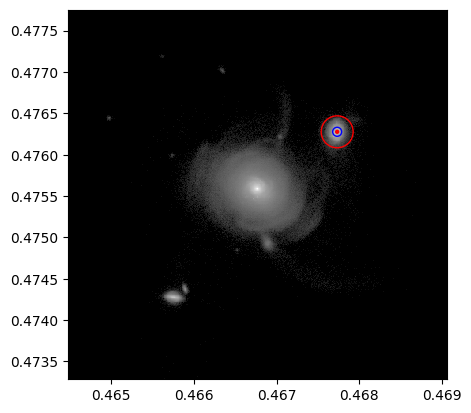

In [30]:

plt.hist2d(star['x'], star['y'], bins=480, norm='log', cmap=plt.cm.Greys_r)
plt.scatter(sat['x'], sat['y'], s=10, edgecolors='none', c='r')
cir = plt.Circle((sat['x'], sat['y']), sat['r'], color='r', fill=False)
plt.gca().add_artist(cir)
cir = plt.Circle((sat['x'], sat['y']), r50m, color='b', fill=False)
plt.gca().add_artist(cir)
plt.gca().set_facecolor('k')
plt.gca().set_aspect('equal')

In [ ]:
with open(f"./database/09_value_added.txt", "r") as f:
    header = f.readline().split()
dtype = [(h, np.float64) for h in header]
dtype[0] = ('Host', np.int32)
dtype[1] = ('Sat', np.int32)
dtype = np.dtype(dtype)
test = np.genfromtxt(f"./database/09_value_added.txt", delimiter='\t', skip_header=1, dtype=dtype)
test